# **Declare path to project directory**

In [1]:
path_to_directory = "/home/antonio/ist/data-science/proj/classification"

# **Data Profiling**
## **Methodology**

/home/antonio/ist/data-science/proj/classification
{'accuracy': [0.1891156462585034, 0.9455782312925171], 'recall': [np.float64(0.975609756097561), np.float64(0.07317073170731707)], 'precision': [np.float64(0.06299212598425197), np.float64(0.6)], 'auc': [np.float64(0.559130526463766), np.float64(0.7190377451324946)], 'f1': [np.float64(0.11834319526627218), np.float64(0.13043478260869565)]}


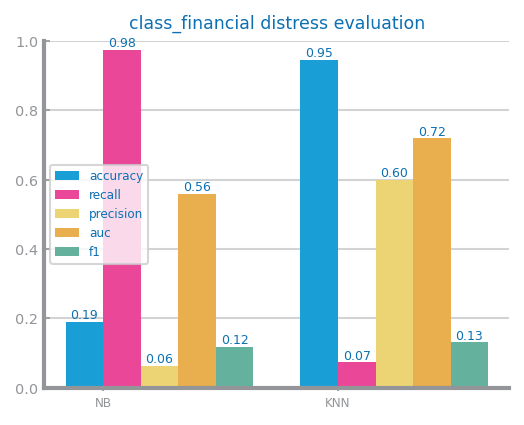

In [2]:
from numpy import ndarray
from pandas import DataFrame, read_csv
from matplotlib.pyplot import savefig, show, figure
from dslabs_functions import plot_multibar_chart, CLASS_EVAL_METRICS, run_KNN
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from dslabs_functions import DELTA_IMPROVE
import os

# get the current working directory
current_working_directory = os.getcwd()

# print output to the console
print(current_working_directory)


def run_NB(trnX, trnY, tstX, tstY, metric: str = "accuracy") -> dict[str, float]:
    estimators: dict[str, GaussianNB | BernoulliNB] = {
        "GaussianNB": GaussianNB(),
        "BernoulliNB": BernoulliNB(),
    }
    best_model: GaussianNB | BernoulliNB = None  # type: ignore
    best_performance: float = 0.0
    eval: dict[str, float] = {}

    for clf in estimators:
        estimators[clf].fit(trnX, trnY)
        prdY: ndarray = estimators[clf].predict(tstX)
        performance: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
        if performance - best_performance > DELTA_IMPROVE:
            best_performance = performance
            best_model = estimators[clf]
    if best_model is not None:
        prd: ndarray = best_model.predict(tstX)
        for key in CLASS_EVAL_METRICS:
            eval[key] = CLASS_EVAL_METRICS[key](tstY, prd)
    return eval

def evaluate_approach(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values
    eval: dict[str, list] = {}

    eval_NB: dict[str, float] = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN: dict[str, float] = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    if eval_NB != {} and eval_KNN != {}:
        for met in CLASS_EVAL_METRICS:
            eval[met] = [eval_NB[met], eval_KNN[met]]
    return eval


target = "CLASS"
file_tag = "class_financial distress"
filename = f"{path_to_directory}/datasets/class_financial distress.csv"
train: DataFrame = read_csv(filepath_or_buffer=filename)

train, test = train_test_split(train, test_size=0.2, random_state=42)

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
print(eval)
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/{file_tag}_eval.png")
show()

## **Variable Encoding**
All variables are numeric and the binary one is already in format '0' or '1'.

Methodology results are the same as the previous.

## **Missing Values Imputation**

Dataset nr records=3672 nr variables=87


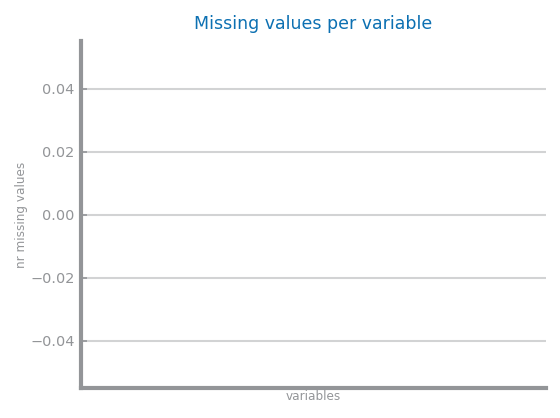

In [3]:
from pandas import read_csv, DataFrame
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_bar_chart

data: DataFrame = read_csv(filepath_or_buffer=filename, na_values="", index_col=None, sep=',', decimal='.')
print(f"Dataset nr records={data.shape[0]}", f"nr variables={data.shape[1]}")

mv: dict[str, int] = {}
figure()
for var in data:
    nr: int = data[var].isna().sum()
    if nr > 0:
        mv[var] = nr

plot_bar_chart(
    list(mv.keys()),
    list(mv.values()),
    title="Missing values per variable",
    xlabel="variables",
    ylabel="nr missing values",
)
show()

No further need to deal with missing values because there are no missing values

Methodology results are the same as the previous.
## **Outliers**
### Dropping Outliers

In [4]:
from pandas import read_csv, DataFrame, Series
from dslabs_functions import (
    NR_STDEV,
    get_variable_types,
    determine_outlier_thresholds_for_var,
)

data: DataFrame = read_csv(filepath_or_buffer=filename, na_values="", index_col=None, sep=',', decimal='.')
print(f"Original data: {data.shape}")

n_std: int = NR_STDEV
n_std = 3
print("n_std=", n_std)

numeric_vars: list[str] = get_variable_types(data)["numeric"]
if numeric_vars is not None:
    df: DataFrame = data.copy(deep=True)
    summary5: DataFrame = data[numeric_vars].describe()
    for var in numeric_vars:
        top_threshold, bottom_threshold = determine_outlier_thresholds_for_var(
            summary5[var], threshold= n_std
        )
        outliers: Series = df[(df[var] > top_threshold) | (df[var] < bottom_threshold)]
        df.drop(outliers.index, axis=0, inplace=True)
    df.to_csv(f"{path_to_directory}/datasets/{file_tag}_drop_outliers.csv", index=False)
    print(f"Data after dropping outliers: {df.shape}")
else:
    print("There are no numeric variables")

Original data: (3672, 87)
n_std= 3
Data after dropping outliers: (2470, 87)


Methodology

{'accuracy': [0.12955465587044535, 0.9777327935222672], 'recall': [np.float64(1.0), np.float64(0.0)], 'precision': [np.float64(0.024943310657596373), np.float64(0.0)], 'auc': [np.float64(0.5548654244306418), np.float64(0.7812911725955204)], 'f1': [np.float64(0.048672566371681415), np.float64(0.0)]}


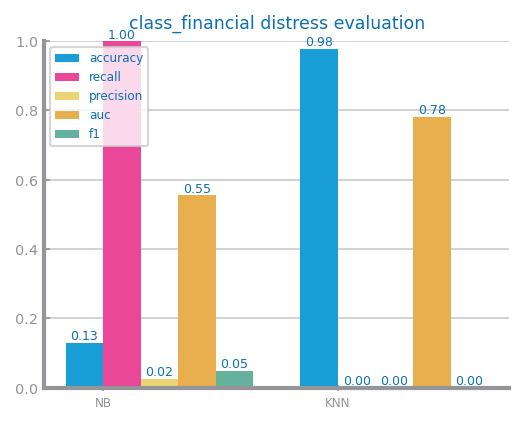

In [5]:
train: DataFrame = read_csv(f"{path_to_directory}/datasets/{file_tag}_drop_outliers.csv")

train, test = train_test_split(train, test_size=0.2, random_state=42)

figure()
eval_dropping: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
print(eval_dropping)
plot_multibar_chart(
    ["NB", "KNN"], eval_dropping, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/{file_tag}_dropping_outliers_eval.png")
show()

### Replacing outliers with fixed value


In [6]:
if [] != numeric_vars:
    df: DataFrame = data.copy(deep=True)
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])
        median: float = df[var].median()
        df[var] = df[var].apply(lambda x: median if x > top or x < bottom else x)
    df.to_csv(f"{path_to_directory}/datasets/{file_tag}_replacing_outliers.csv", index=False)
    print("Data after replacing outliers:", df.shape)
    print(df.describe())
else:
    print("There are no numeric variables")

Data after replacing outliers: (3672, 87)
           Company         Time  Financial Distress        CLASS           x1  \
count  3672.000000  3672.000000         3672.000000  3672.000000  3672.000000   
mean    180.299292     7.528322            0.882825     0.037037     1.286091   
std     115.289514     4.064016            1.201236     0.188878     0.579206   
min       1.000000     1.000000           -4.063300     0.000000     0.075170   
25%      80.000000     4.000000            0.174423     0.000000     0.952145   
50%     168.000000     7.000000            0.583805     0.000000     1.183550   
75%     262.000000    11.000000            1.278950     0.000000     1.479075   
max     416.000000    14.000000            6.312400     1.000000     4.289400   

                x2           x3            x4           x5           x6  ...  \
count  3672.000000  3672.000000  3.672000e+03  3672.000000  3672.000000  ...   
mean      0.115923     0.632942  7.944232e-01     0.140659     0.101

Methodology

{'accuracy': [0.17006802721088435, 0.9442176870748299], 'recall': [np.float64(0.9512195121951219), np.float64(0.07317073170731707)], 'precision': [np.float64(0.06027820710973725), np.float64(0.5)], 'auc': [np.float64(0.5375694102762353), np.float64(0.7098123286708372)], 'f1': [np.float64(0.11337209302325581), np.float64(0.1276595744680851)]}


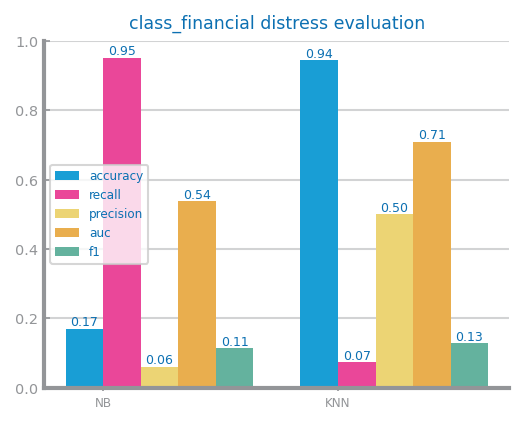

In [7]:
train: DataFrame = read_csv(f"{path_to_directory}/datasets/{file_tag}_replacing_outliers.csv")

train, test = train_test_split(train, test_size=0.2, random_state=42)

figure()
eval_replacing: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
print(eval_replacing)
plot_multibar_chart(
    ["NB", "KNN"], eval_replacing, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/{file_tag}_replacing_outliers_eval.png")
show()

### Truncating outliers


In [8]:
if [] != numeric_vars:
    df: DataFrame = data.copy(deep=True)
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])
        df[var] = df[var].apply(
            lambda x: top if x > top else bottom if x < bottom else x
        )
    df.to_csv(f"{path_to_directory}/datasets/{file_tag}_truncate_outliers.csv", index=False)
    print("Data after truncating outliers:", df.shape)
    print(df.describe())
else:
    print("There are no numeric variables")

Data after truncating outliers: (3672, 87)
           Company         Time  Financial Distress        CLASS           x1  \
count  3672.000000  3672.000000         3672.000000  3672.000000  3672.000000   
mean    182.056230     7.528322            0.968539     0.037037     1.330980   
std     116.967639     4.064016            1.390794     0.188878     0.681107   
min       1.000000     1.000000           -4.264198     0.000000     0.075170   
25%      80.000000     4.000000            0.172275     0.000000     0.952145   
50%     168.000000     7.000000            0.583805     0.000000     1.183600   
75%     264.250000    11.000000            1.351750     0.000000     1.506475   
max     416.133694    14.000000            6.344711     1.000000     4.293672   

                x2           x3            x4           x5           x6  ...  \
count  3672.000000  3672.000000  3.672000e+03  3672.000000  3672.000000  ...   
mean      0.126114     0.618399  8.371999e-01     0.151653     0.10

Methodology

{'accuracy': [0.2680272108843537, 0.9455782312925171], 'recall': [np.float64(0.9024390243902439), np.float64(0.07317073170731707)], 'precision': [np.float64(0.0647985989492119), np.float64(0.6)], 'auc': [np.float64(0.5664932874112603), np.float64(0.7190377451324946)], 'f1': [np.float64(0.12091503267973856), np.float64(0.13043478260869565)]}


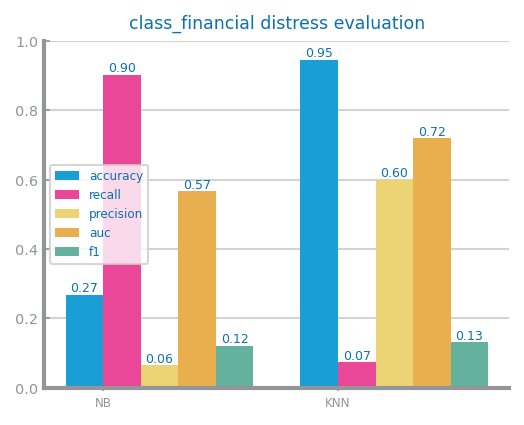

In [9]:
train: DataFrame = read_csv(f"{path_to_directory}/datasets/{file_tag}_truncate_outliers.csv")

train, test = train_test_split(train, test_size=0.2, random_state=42)

figure()
eval_truncate: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
print(eval_truncate)
plot_multibar_chart(
    ["NB", "KNN"], eval_truncate, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/{file_tag}_truncate_outliers_eval.png")
show()

### Outlier method evaluation

In [10]:
# # Combine all evaluations into a list
# evaluations = {"original": eval, "drop": eval_dropping, "replacing": eval_replacing, "truncate": eval_truncate}

# # Variables to track the best recalls
# best_recall_NB = -float("inf")
# best_recall_KNN = -float("inf")
# best_eval_NB = None
# best_eval_KNN = None

# # Iterate through evaluations and print recalls
# for eval_name, eval_dict in evaluations.items():
#     recall_NB = eval_dict["recall"][0]  # First index for NB
#     recall_KNN = eval_dict["recall"][1]  # Second index for KNN
#     print(f"{eval_name}: NB Recall = {recall_NB}, KNN Recall = {recall_KNN}")

#     # Update the best recall for NB
#     if recall_NB > best_recall_NB:
#         best_recall_NB = recall_NB
#         best_eval_NB = eval_name

#     # Update the best recall for KNN
#     if recall_KNN > best_recall_KNN:
#         best_recall_KNN = recall_KNN
#         best_eval_KNN = eval_name

# # Print the best recalls
# print(f"\nBest NB Recall: {best_recall_NB} from {best_eval_NB}")
# print(f"Best KNN Recall: {best_recall_KNN} from {best_eval_KNN}")

# if best_eval_NB == "original" and best_eval_KNN == "original":
#     filename = f"/home/morais/data_science_project/datasets/{file_tag}.csv"
# elif best_eval_NB == "dropping" and best_eval_KNN == "dropping":
#     filename = f"/home/morais/data_science_project/datasets/{file_tag}_drop_outliers.csv"
# elif best_eval_NB == "replacing" and best_eval_KNN == "replacing":
#     filename = f"/home/morais/data_science_project/datasets/{file_tag}_replacing_outliers.csv"
# elif best_eval_NB == "truncate" and best_eval_KNN == "truncate":
#     filename = f"/home/morais/data_science_project/datasets/{file_tag}_truncate_outliers.csv"

In [11]:
evaluations = {"original": eval, "drop": eval_dropping, "replacing": eval_replacing, "truncate": eval_truncate}

best_mean = -float("inf")
best_mean_NB = -float("inf")
best_mean_KNN = -float("inf")
best_eval = None
best_eval_NB = None
best_eval_KNN = None

for eval_name, eval_dict in evaluations.items():
    # Calculate mean for NB and KNN using generator expressions
    mean_NB = sum(eval_dict[metric][0] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
    mean_KNN = sum(eval_dict[metric][1] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
    
    # Print means
    print(f"{eval_name}: Mean NB = {mean_NB}, Mean KNN = {mean_KNN}")

    # Update the best mean for NB
    if mean_NB > best_mean_NB:
        best_mean_NB = mean_NB
        best_eval_NB = eval_name

    # Update the best mean for KNN
    if mean_KNN > best_mean_KNN:
        best_mean_KNN = mean_KNN
        best_eval_KNN = eval_name

# Print the best mean scores
print(f"\nBest Mean NB: {best_mean_NB} from {best_eval_NB}")
print(f"Best Mean KNN: {best_mean_KNN} from {best_eval_KNN}")

if best_mean_NB > best_mean_KNN:
    best_mean = best_mean_NB
    best_eval = best_eval_NB
else:
    best_mean = best_mean_KNN
    best_eval = best_eval_KNN

print(f"\nContinuing with Best Mean: {best_mean} from {best_eval}")

# Determine the filename based on the best evaluations
if best_eval == "original":
    filename = f"{path_to_directory}/datasets/{file_tag}.csv"
elif best_eval == "dropping":
    filename = f"{path_to_directory}/datasets/{file_tag}_drop_outliers.csv"
elif best_eval == "replacing":
    filename = f"{path_to_directory}/datasets/{file_tag}_replacing_outliers.csv"
elif best_eval == "truncate":
    filename = f"{path_to_directory}/datasets/{file_tag}_truncate_outliers.csv"

original: Mean NB = 0.3810382500140709, Mean KNN = 0.4936442981482049
drop: Mean NB = 0.35160719146607294, Mean KNN = 0.3518047932235575
replacing: Mean NB = 0.3665014499630469, Mean KNN = 0.47097206438421385
truncate: Mean NB = 0.3845346308629617, Mean KNN = 0.4936442981482049

Best Mean NB: 0.3845346308629617 from truncate
Best Mean KNN: 0.4936442981482049 from original

Continuing with Best Mean: 0.4936442981482049 from original


## **Scaling**
### Standard Scaler

In [12]:
from pandas import read_csv, DataFrame, Series
from sklearn.preprocessing import StandardScaler


# Load the dataset
data: DataFrame = read_csv(filename)
target = "CLASS"

# Separate the target column
target_data: Series = data.pop(target).copy()  # Use .copy() to ensure immutability

# Scale only the feature variables
scaler = StandardScaler(with_mean=True, with_std=True, copy=True)
scaled_features = scaler.fit_transform(data)

# Create a DataFrame for the scaled data
df_zscore = DataFrame(scaled_features, columns=data.columns, index=data.index)

# Insert the target variable at the 4th index (Python index 3)
df_zscore.insert(3, target, target_data)

# Save the final DataFrame
df_zscore.to_csv(f"{path_to_directory}/datasets/{file_tag}_scaled_zscore.csv", index=False)

#### KNN results

{'accuracy': [0.9469387755102041], 'recall': [np.float64(0.04878048780487805)], 'precision': [np.float64(1.0)], 'auc': [np.float64(0.7161734729739229)], 'f1': [np.float64(0.09302325581395349)]}


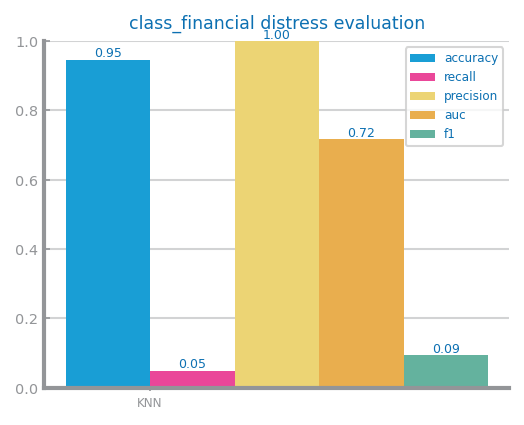

In [13]:
def evaluate_approach(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
    # Separate features and target variables
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values

    # Evaluate KNN
    eval_KNN: dict[str, float] = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    
    # Create evaluation dictionary
    eval: dict[str, list] = {}
    for met in CLASS_EVAL_METRICS:
        eval[met] = [eval_KNN[met]]  # Only store KNN results as a single-entry list

    return eval


train, test = train_test_split(df_zscore, test_size=0.2, random_state=42)

figure()
eval_zscore: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
print(eval_zscore)
plot_multibar_chart(
    ["KNN"], eval_zscore, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/{file_tag}_standard_scaler_eval.png")
show()

### MinMax Scaler


In [14]:
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, Series, read_csv

# Load data
data: DataFrame = read_csv(filename)
target = "CLASS"
vars: list[str] = data.columns.to_list()

# Separate target column
target_data: Series = data.pop(target)

# Apply MinMaxScaler to the remaining columns
transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(data)
df_minmax = DataFrame(transf.transform(data), index=data.index, columns=data.columns)

# Reinsert the target column at the 4th index
df_minmax.insert(3, target, target_data)

# Rename columns to match original variable names
df_minmax.columns = vars

# Save the resulting DataFrame
df_minmax.to_csv(f"{path_to_directory}/datasets/{file_tag}_scaled_minmax.csv", index=False)

#### KNN results

{'accuracy': [0.9455782312925171], 'recall': [np.float64(0.024390243902439025)], 'precision': [np.float64(1.0)], 'auc': [np.float64(0.6846840514514655)], 'f1': [np.float64(0.047619047619047616)]}


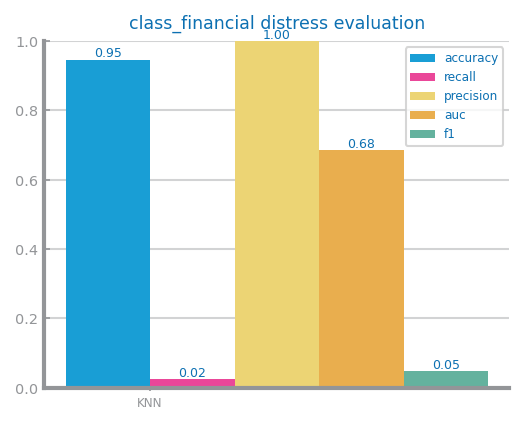

In [15]:
train, test = train_test_split(df_minmax, test_size=0.2, random_state=42)

figure()
eval_minmax: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
print(eval_minmax)
plot_multibar_chart(
    ["KNN"], eval_minmax, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/{file_tag}_minmax_eval.png")
show()

### Transformed data in boxplot

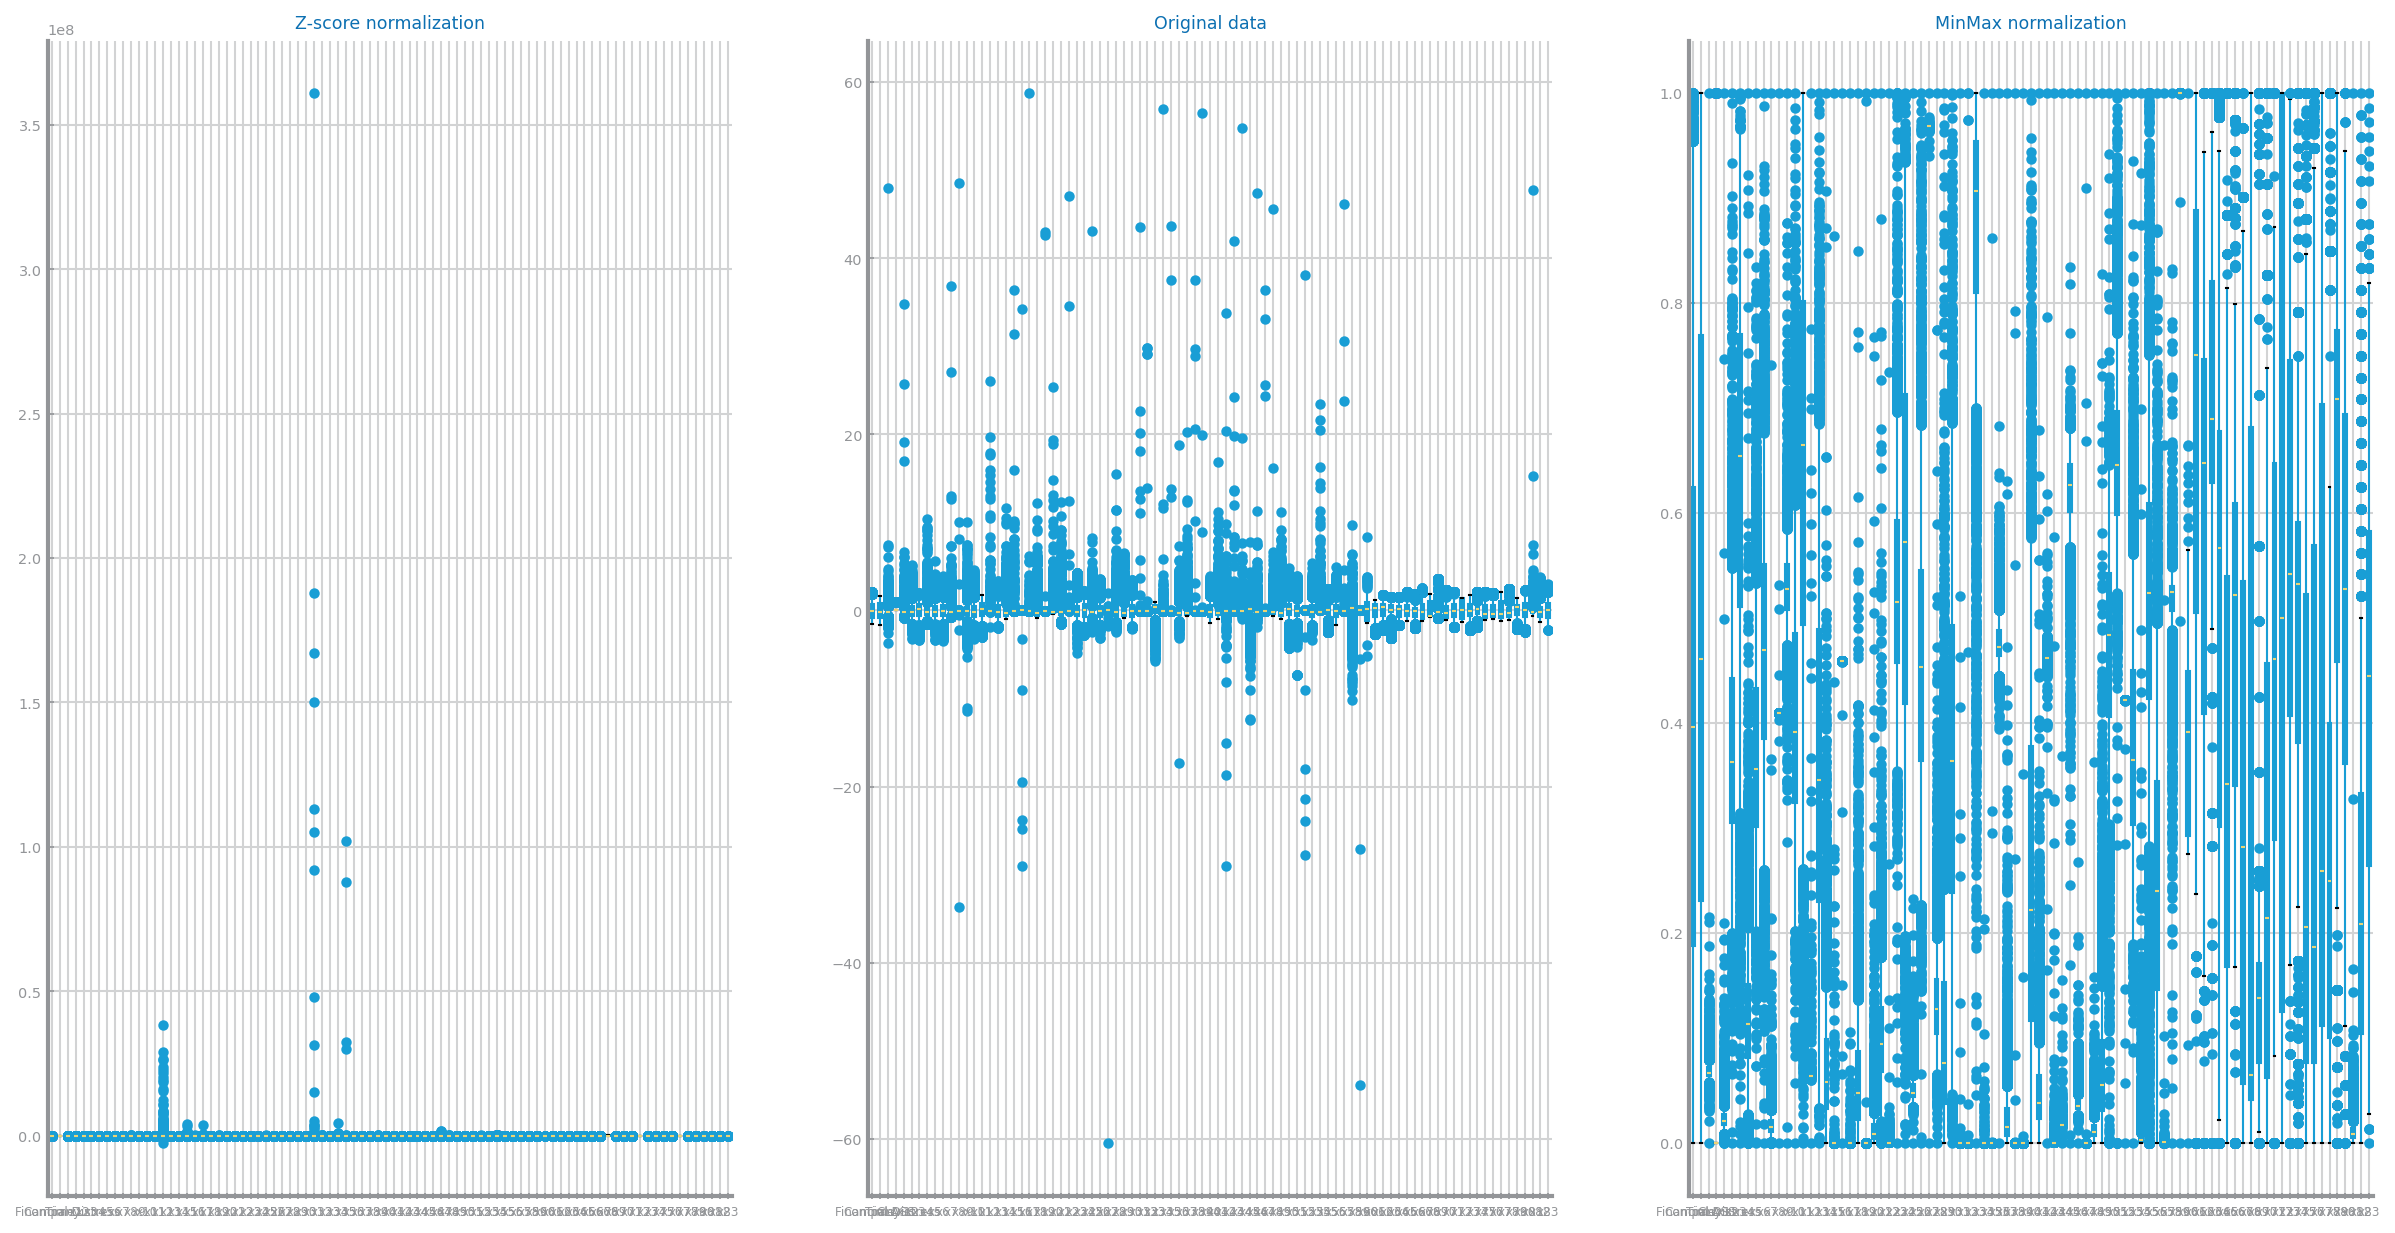

In [16]:
from matplotlib.pyplot import subplots, show

fig, axs = subplots(1, 3, figsize=(20, 10), squeeze=False)
axs[0, 1].set_title("Original data")
data.boxplot(ax=axs[0, 0])
axs[0, 0].set_title("Z-score normalization")
df_zscore.boxplot(ax=axs[0, 1])
axs[0, 2].set_title("MinMax normalization")
df_minmax.boxplot(ax=axs[0, 2])
show()

### Scaling method evaluation

In [17]:
print("Continuing from", best_eval)

evaluations = {"original": eval, "standard_scaler": eval_zscore, "minmax": eval_minmax}

best_mean = -float("inf")
mean = -float("inf")
best_eval = None

for eval_name, eval_dict in evaluations.items():
    if eval_name == "original":
        mean = sum(eval_dict[metric][1] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
    else:
        mean = sum(eval_dict[metric][0] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
    
    # Print means
    print(f"{eval_name}: Mean = {mean}")

    # Update the best mean
    if mean > best_mean:
        best_mean = mean
        best_eval = eval_name

# Print the best mean scores
print(f"\nContinuing with Best Mean: {best_mean} from {best_eval}")

Continuing from original
original: Mean = 0.4936442981482049
standard_scaler: Mean = 0.5609831984205917
minmax: Mean = 0.5404543148530938

Continuing with Best Mean: 0.5609831984205917 from standard_scaler


## Redifine Evaluate approach to use NB

In [18]:
def evaluate_approach(
    train: DataFrame,
    test: DataFrame,
    target: str = "class",
    metric: str = "accuracy",
    evaluate_nb: bool = True,
    evaluate_knn: bool = True
) -> dict[str, list]:
    # Separate features and target variables
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values

    eval: dict[str, list] = {}
    if evaluate_nb:
        # Evaluate Naive Bayes
        eval_NB: dict[str, float] = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    else:
        eval_NB = {metric: None for metric in CLASS_EVAL_METRICS}

    if evaluate_knn:
        # Evaluate KNN
        eval_KNN: dict[str, float] = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    else:
        eval_KNN = {metric: None for metric in CLASS_EVAL_METRICS}

    # Combine results into a list for each metric
    for met in CLASS_EVAL_METRICS:
        eval[met] = [eval_NB[met], eval_KNN[met]]

    return eval


## Feature Engineering

In [19]:
# Prepare data based on the best scaling method
if best_eval == 'original':
    data = data  # Original data
elif best_eval == 'standard_scaler':
    data = df_zscore
elif best_eval == 'minmax':
    data = df_minmax

# Split into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


## Dropping Low Variance Variables

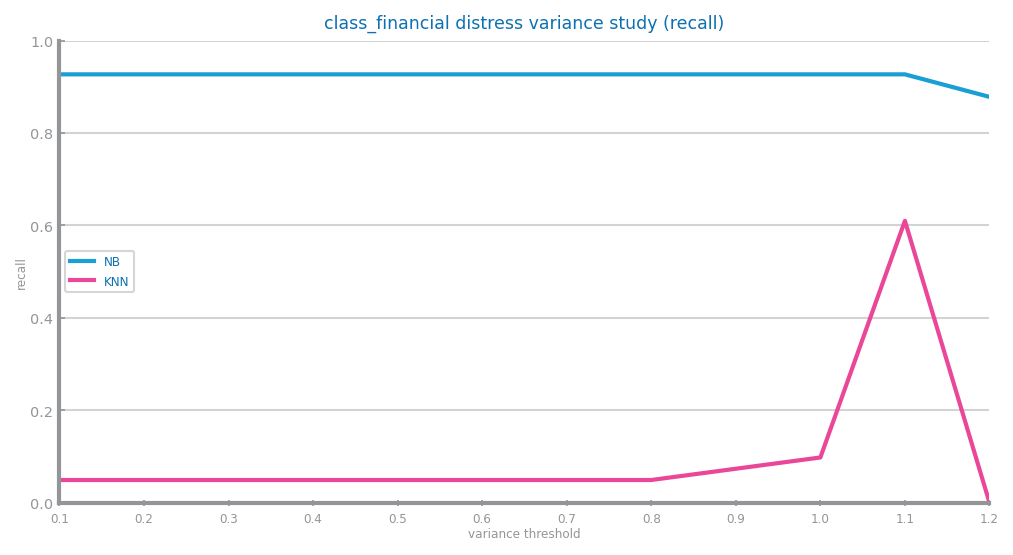

In [20]:
from dslabs_functions import study_variance_for_feature_selection

eval_metric = "recall"
HEIGHT: int = 4

figure(figsize=(2 * HEIGHT, HEIGHT))
study_variance_for_feature_selection(
    train_data,
    test_data,
    target=target,
    max_threshold=1.2,
    lag=0.1,
    metric=eval_metric,
    file_tag=file_tag,
)
savefig(f"{path_to_directory}/images/{file_tag}_fs_low_var_{eval_metric}_study.png")
show()


In [21]:
from dslabs_functions import select_low_variance_variables 

def apply_feature_selection(
    train: DataFrame,
    test: DataFrame,
    vars2drop: list,
    filename: str = "",
    tag: str = "",
) -> tuple[DataFrame, DataFrame]:
    train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
    test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
    return train_copy, test_copy


In [22]:
vars2drop: list[str] = select_low_variance_variables(
    train_data, max_threshold=1.2, target=target
)
train_lv, test_lv = apply_feature_selection(
    train_data, test_data, vars2drop, filename=f"{file_tag}", tag="lowvar"
)
print(f"Original data: train={train_data.shape}, test={test_data.shape}")
print(f"After low variance FS: train_lv={train_lv.shape}, test_lv={test_lv.shape}")


Original data: train=(2937, 87), test=(735, 87)
After low variance FS: train_lv=(2937, 6), test_lv=(735, 6)


{'accuracy': [0.14285714285714285, 0.9414965986394558], 'recall': [np.float64(0.8780487804878049), np.float64(0.0)], 'precision': [np.float64(0.05446293494704992), np.float64(0.0)], 'auc': [np.float64(0.4887362058058621), np.float64(0.6303155971040979)], 'f1': [np.float64(0.10256410256410256), np.float64(0.0)]}


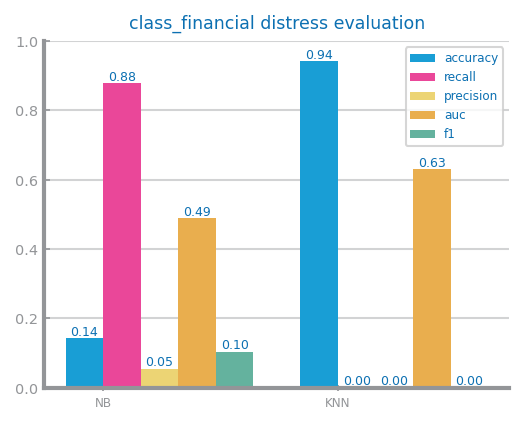

In [23]:
figure()
eval_lv: dict[str, list] = evaluate_approach(train_lv, test_lv, target=target, metric=eval_metric)
print(eval_lv)
plot_multibar_chart(
    ["NB", "KNN"], eval_lv, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/{file_tag}_low_variance_eval.png")
show()


In [24]:
from pandas import Series
from dslabs_functions import select_redundant_variables

print("Original variables", train_data.columns.values)
vars2drop: list[str] = select_redundant_variables(
    train_data, target=target, min_threshold=0.5
)
print("Variables to drop", vars2drop)


Original variables ['Company' 'Time' 'Financial Distress' 'CLASS' 'x1' 'x2' 'x3' 'x4' 'x5'
 'x6' 'x7' 'x8' 'x9' 'x10' 'x11' 'x12' 'x13' 'x14' 'x15' 'x16' 'x17' 'x18'
 'x19' 'x20' 'x21' 'x22' 'x23' 'x24' 'x25' 'x26' 'x27' 'x28' 'x29' 'x30'
 'x31' 'x32' 'x33' 'x34' 'x35' 'x36' 'x37' 'x38' 'x39' 'x40' 'x41' 'x42'
 'x43' 'x44' 'x45' 'x46' 'x47' 'x48' 'x49' 'x50' 'x51' 'x52' 'x53' 'x54'
 'x55' 'x56' 'x57' 'x58' 'x59' 'x60' 'x61' 'x62' 'x63' 'x64' 'x65' 'x66'
 'x67' 'x68' 'x69' 'x70' 'x71' 'x72' 'x73' 'x74' 'x75' 'x76' 'x77' 'x78'
 'x79' 'x80' 'x81' 'x82' 'x83']
Variables to drop ['x61', 'x62', 'x64', 'x68', 'x73', 'x75', 'x76', 'x77', 'x6', 'x7', 'x20', 'x43', 'x44', 'x46', 'x3', 'x5', 'x9', 'x10', 'x13', 'x23', 'x36', 'x50', 'x53', 'x2', 'x14', 'x24', 'x41', 'x49', 'x21', 'x1', 'x11', 'x45', 'x30', 'x33', 'x40', 'x56', 'x18', 'x48', 'x81', 'x37', 'x35', 'x38', 'x29', 'x32', 'x4', 'x25', 'x8', 'x19', 'Time', 'x63', 'x70', 'x71', 'x72', 'x79', 'x78', 'x74']


## Droping redundant variables 

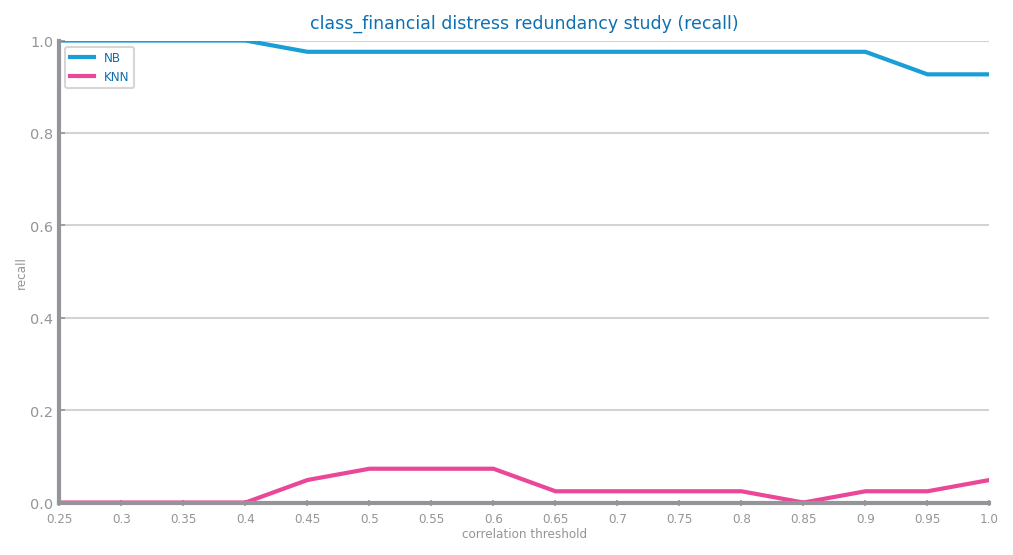

In [25]:
from dslabs_functions import study_redundancy_for_feature_selection

figure(figsize=(2 * HEIGHT, HEIGHT))
study_redundancy_for_feature_selection(
    train_data,
    test_data,
    target=target,
    min_threshold=0.25,
    lag=0.05,
    metric=eval_metric,
    file_tag=file_tag,
)
savefig(f"{path_to_directory}/images/{file_tag}_fs_redundancy_{eval_metric}_study.png")
show()


In [26]:
vars2drop: list[str] = select_redundant_variables(
    train_data, min_threshold=0.45, target=target
)
train_rv, test_rv = apply_feature_selection(
    train_data, test_data, vars2drop, filename=f"{file_tag}", tag="redundant_vars"
)
print(f"Original data: train={train_data.shape}, test={test_data.shape}")
print(f"After redundant FS: train_rv={train_rv.shape}, test_rv={test_rv.shape}")


Original data: train=(2937, 87), test=(735, 87)
After redundant FS: train_rv=(2937, 23), test_rv=(735, 23)


{'accuracy': [0.1469387755102041, 0.9469387755102041], 'recall': [np.float64(0.975609756097561), np.float64(0.04878048780487805)], 'precision': [np.float64(0.06006006006006006), np.float64(1.0)], 'auc': [np.float64(0.5367962325156393), np.float64(0.7128347508258943)], 'f1': [np.float64(0.11315417256011315), np.float64(0.09302325581395349)]}


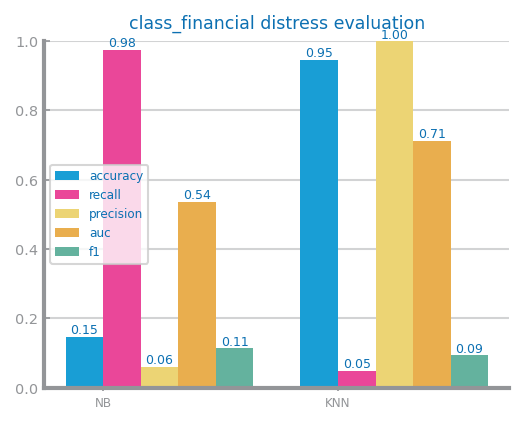

In [27]:
figure()
eval_rv: dict[str, list] = evaluate_approach(train_rv, test_rv, target=target, metric=eval_metric)
print(eval_rv)
plot_multibar_chart(
    ["NB", "KNN"], eval_rv, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/{file_tag}_redundant_variables_eval.png")
show()

In [28]:
print("Continuing from", best_eval)

evaluations = {"original": eval, "Dropping Redundant Variables": eval_rv, "Dropping Low Variance Variables": eval_lv}

best_mean = -float("inf")
mean = -float("inf")
best_eval = None

for eval_name, eval_dict in evaluations.items():
    if eval_name == "original":
        mean = sum(eval_dict[metric][1] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
    else:
        mean = sum(eval_dict[metric][0] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
    
    # Print means
    print(f"{eval_name}: Mean = {mean}")

    # Update the best mean
    if mean > best_mean:
        best_mean = mean
        best_eval = eval_name

# Print the best mean scores
print(f"\nContinuing with Best Mean: {best_mean} from {best_eval}")

Continuing from standard_scaler
original: Mean = 0.4936442981482049
Dropping Redundant Variables: Mean = 0.36651179934871553
Dropping Low Variance Variables: Mean = 0.3333338333323925

Continuing with Best Mean: 0.4936442981482049 from original


## Data Balancing
### Undersampling

Minority class= 1 : 136
Majority class= 0 : 3536
Proportion: 0.04 : 1


<Axes: title={'center': 'Class balance'}>

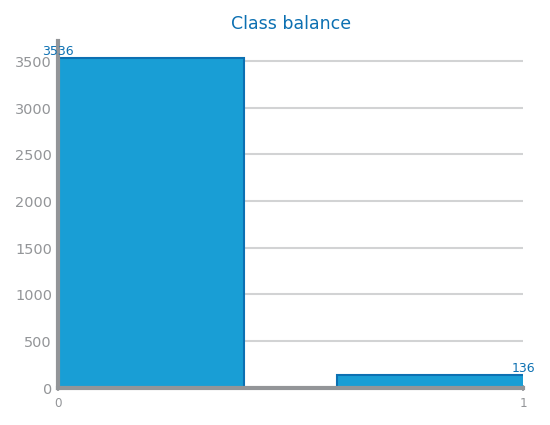

In [29]:
original: DataFrame = read_csv(filename)
target_count: Series = original[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

print("Minority class=", positive_class, ":", target_count[positive_class])
print("Majority class=", negative_class, ":", target_count[negative_class])
print(
    "Proportion:",
    round(target_count[positive_class] / target_count[negative_class], 2),
    ": 1",
)
values: dict[str, list] = {
    "Original": [target_count[positive_class], target_count[negative_class]]
}

figure()
plot_bar_chart(
    target_count.index.to_list(), target_count.to_list(), title="Class balance"
)

In [30]:
df_positives: Series = original[original[target] == positive_class]
df_negatives: Series = original[original[target] == negative_class]

In [31]:
from pandas import concat

df_neg_sample: DataFrame = DataFrame(df_negatives.sample(len(df_positives)))
df_under: DataFrame = concat([df_positives, df_neg_sample], axis=0)
df_under.to_csv(f"data_under.csv", index=False)

print("Minority class=", positive_class, ":", len(df_positives))
print("Majority class=", negative_class, ":", len(df_neg_sample))
print("Proportion:", round(len(df_positives) / len(df_neg_sample), 2), ": 1")

Minority class= 1 : 136
Majority class= 0 : 136
Proportion: 1.0 : 1


{'accuracy': [0.8181818181818182, 0.7090909090909091], 'recall': [np.float64(0.7241379310344828), np.float64(0.7586206896551724)], 'precision': [np.float64(0.9130434782608695), np.float64(0.7096774193548387)], 'auc': [np.float64(0.8236074270557029), np.float64(0.7877984084880637)], 'f1': [np.float64(0.8076923076923077), np.float64(0.7333333333333333)]}


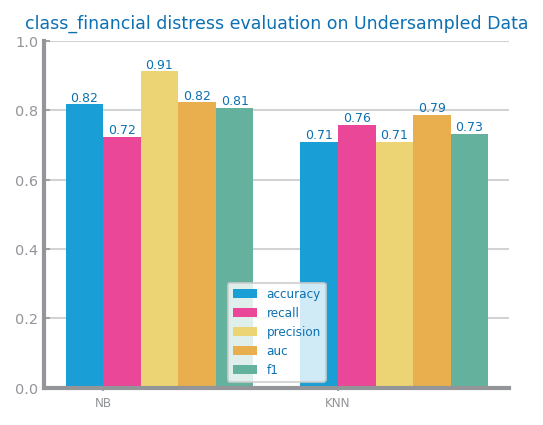

In [32]:
train_under, test_under = train_test_split(df_under, test_size=0.2, random_state=42)

# Evaluate approach on undersampled data
figure()
eval_under: dict[str, list] = evaluate_approach(
    train_under, test_under, target=target, metric=eval_metric, evaluate_nb=True, evaluate_knn=True
)
print(eval_under)
plot_multibar_chart(
    ["NB", "KNN"], eval_under, title=f"{file_tag} evaluation on Undersampled Data", percentage=True
)
savefig(f"{path_to_directory}/images/{file_tag}_undersampled_eval.png")
show()


### SMOTE

In [33]:
from numpy import ndarray
from pandas import Series
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42

original: DataFrame = read_csv(filename)
target = "CLASS"

smote: SMOTE = SMOTE(sampling_strategy="minority", random_state=RANDOM_STATE)
y = original.pop(target).values
X: ndarray = original.values
smote_X, smote_y = smote.fit_resample(X, y)
df_smote: DataFrame = concat([DataFrame(smote_X), DataFrame(smote_y)], axis=1)
df_smote.columns = list(original.columns) + [target]
df_smote.to_csv(f"data_smote.csv", index=False)

smote_target_count: Series = Series(smote_y).value_counts()
print("Minority class=", positive_class, ":", smote_target_count[positive_class])
print("Majority class=", negative_class, ":", smote_target_count[negative_class])
print(
    "Proportion:",
    round(smote_target_count[positive_class] / smote_target_count[negative_class], 2),
    ": 1",
)
print(df_smote.shape)



Minority class= 1 : 3536
Majority class= 0 : 3536
Proportion: 1.0 : 1
(7072, 87)


{'accuracy': [0.5434628975265018, 0.9137809187279152], 'recall': [np.float64(0.9768451519536903), np.float64(0.9710564399421129)], 'precision': [np.float64(0.5172413793103449), np.float64(0.8680465717981889)], 'auc': [np.float64(0.5533397030486683), np.float64(0.9658204140048452)], 'f1': [np.float64(0.6763527054108216), np.float64(0.9166666666666666)]}


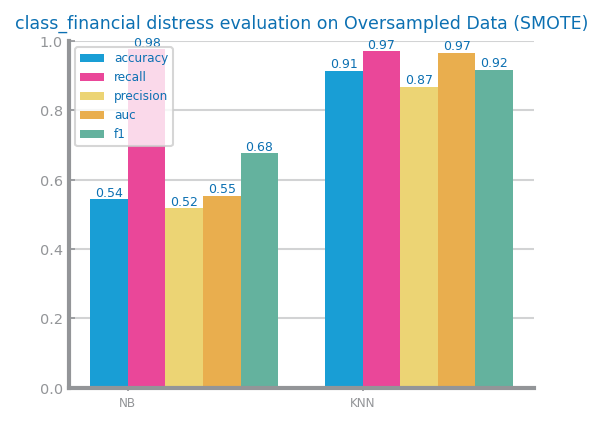

In [34]:
# Split into train and test sets
train_smote, test_smote = train_test_split(df_smote, test_size=0.2, random_state=42)

# Evaluate approach on oversampled data
figure()
eval_smote: dict[str, list] = evaluate_approach(
    train_smote, test_smote, target=target, metric=eval_metric, evaluate_nb=True, evaluate_knn=True
)
print(eval_smote)
plot_multibar_chart(
    ["NB", "KNN"], eval_smote, title=f"{file_tag} evaluation on Oversampled Data (SMOTE)", percentage=True
)
savefig(f"{path_to_directory}/images/{file_tag}_oversampled_eval.png")
show()


In [35]:
print("Continuing from", best_eval)

evaluations = {"original": eval, "Undersampling": eval_under, "Oversampling with SMOTE": eval_smote}

best_mean = -float("inf")
mean = -float("inf")
best_eval = None

for eval_name, eval_dict in evaluations.items():
    if eval_name == "original":
        mean = sum(eval_dict[metric][1] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
    else:
        mean = sum(eval_dict[metric][0] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
    
    # Print means
    print(f"{eval_name}: Mean = {mean}")

    # Update the best mean
    if mean > best_mean:
        best_mean = mean
        best_eval = eval_name

# Print the best mean scores
print(f"\nContinuing with Best Mean: {best_mean} from {best_eval}")

Continuing from original
original: Mean = 0.4936442981482049
Undersampling: Mean = 0.8173325924450362
Oversampling with SMOTE: Mean = 0.6534483674500053

Continuing with Best Mean: 0.8173325924450362 from Undersampling
